In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [11]:
chars = sorted(set(list("".join(words))))

stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

context_window = 3

def create_dataset(words):
    X, y = [], []
    for word in words:
        context = [0] * context_window
        for char in word + ".":
            X.append(context)
            y.append(stoi[char])
            context = context[1:] + [stoi[char]]
    return torch.tensor(X), torch.tensor(y)

import random
random.seed(42)
random.shuffle(words)

m = len(words)
n_train = int(0.8 * m)
n_dev = int(0.9 * m)

X_train, y_train = create_dataset(words[:n_train])
X_dev, y_dev = create_dataset(words[n_train:n_dev])
X_test, y_test = create_dataset(words[n_dev:])

In [12]:
(X_train.shape, y_train.shape), (X_dev.shape, y_dev.shape), (X_test.shape, y_test.shape)

((torch.Size([182424, 3]), torch.Size([182424])),
 (torch.Size([22836, 3]), torch.Size([22836])),
 (torch.Size([22886, 3]), torch.Size([22886])))

In [27]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((10*context_window, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

lr = 0.1
batch_size = 32
epochs = 200_000

for p in parameters:
    p.requires_grad = True

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[batch]].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[batch])
    for p in parameters:
        p.grad = None
    loss.backward()
    if epoch >= 100_000: lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if epoch % 20_000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 25.17213249206543
Epoch: 20000 | Loss: 2.2076988220214844
Epoch: 40000 | Loss: 2.1944916248321533
Epoch: 60000 | Loss: 2.4294729232788086
Epoch: 80000 | Loss: 2.785818576812744
Epoch: 100000 | Loss: 2.058749198913574
Epoch: 120000 | Loss: 2.176015853881836
Epoch: 140000 | Loss: 2.3001980781555176
Epoch: 160000 | Loss: 1.9298157691955566
Epoch: 180000 | Loss: 1.9758315086364746


In [28]:
with torch.inference_mode():
    emb = C[X_train].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    train_loss = F.cross_entropy(logits, y_train)

    emb = C[X_test].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    test_loss = F.cross_entropy(logits, y_test)

    print(f"Train loss: {train_loss}")
    print(f"Test loss: {test_loss}")


Train loss: 2.114173173904419
Test loss: 2.1703128814697266


In [65]:
# Sampling from our model (CPU goes brrrrrrrrr!!!)

for i in range(10):
    res = ""
    context = [0] * context_window
    while True:
        emb = C[context].view(1, 30)
        h = F.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        res += itos[ix]
    print(res)

jayvion
luchaetkaliq
marylondoldin
coleah
ore
rixtyn
dalchelniana
ron
jakyelina
eprislaniel


# Let's find out issues with our current implementation.
1) Initiall loss on the first iteration is too high.
It means that our parameters are not initialized effectively. Let's see why:
It would be sane to start with *uniform distibution* of probabilities initially (network doesn't know anything yet, so it rates all tokens as equally likely).<br>
Loss we would get is log(C), where C is number of classes (Unwrapped it in previous notebook in exercise 2).<br>
In our case it's log(27) = 3.2958.
Our starting loss is definitely is higher than that.
It happens when some wrong classes get high probability scores. Let's see our logits.
Oh shit... You see that?<br>
They are not only non-uniform, but some of them are high!
After couple of iterations our loss normalizes & it is accomplished through lowering parameter values.<br>
We could initialize W2 and b2 to be smaller.
Let's see what it gives us.<br>
But zero initialization is... well scarry since in some cases it can cause problem of **symmetry**
when for every single training sample we'd get the same gradient per neuron. Such optimization will result in symmetrical outputs, when model returns same results, not caring about the input.

In [80]:
"""
Poorly Initialized Parameters
"""
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((10*context_window, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

batch = torch.randint(0, X_train.shape[0], (batch_size,))
emb = C[X_train[batch]].view(-1, 10*context_window)
h = F.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train[batch])
print(logits[0])  # What the hell is this?
print(loss.item())

tensor([-13.8007,   9.1383,  22.5345,   0.0853,   3.7295,  -6.3219,   1.5554,
         -8.2510,   9.0118,  -3.4734,  22.7283,  10.6371,  15.7191,  -7.9939,
          6.9676,  22.4644,  -5.0212,   3.7578,  -4.6100,  -4.1217,  -1.7779,
         -8.9490,   4.7674,   8.5644,   4.6922,   0.0593,   5.1524])
22.75632095336914


In [86]:
"""
Better Initialization of Parameters
"""
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((10*context_window, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) * 0.1
b2 = torch.randn(27, generator=g) * 0.1

batch = torch.randint(0, X_train.shape[0], (batch_size,))
emb = C[X_train[batch]].view(-1, 10*context_window)
h = F.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train[batch])
print(logits[0])  # See? It's so much better!!!
print(loss.item())

tensor([ 3.0385e-01, -5.7750e-01,  1.4345e+00, -1.7574e+00,  3.1687e-01,
         5.2451e-01, -1.5158e+00,  3.7257e-01, -1.6359e+00,  1.3088e+00,
         8.0918e-01, -4.2073e-01,  6.6675e-01, -2.2583e+00, -2.0199e-02,
         3.8703e+00, -7.9721e-02,  6.8691e-01,  1.1312e+00,  1.3989e-03,
        -6.6996e-01,  7.9685e-01, -1.3574e+00, -7.0252e-01,  1.1120e+00,
        -1.6872e-01,  2.1503e+00])
3.74943470954895


In [88]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((10*context_window, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.01

parameters = [C, W1, b1, W2, b2]

lr = 0.1
batch_size = 32
epochs = 200_000

for p in parameters:
    p.requires_grad = True

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[batch]].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[batch])
    for p in parameters:
        p.grad = None
    loss.backward()
    if epoch >= 100_000: lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if epoch % 20_000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 3.2893221378326416
Epoch: 20000 | Loss: 1.9850728511810303
Epoch: 40000 | Loss: 2.1754865646362305
Epoch: 60000 | Loss: 2.109278917312622
Epoch: 80000 | Loss: 2.0592286586761475
Epoch: 100000 | Loss: 1.7330431938171387
Epoch: 120000 | Loss: 2.3761301040649414
Epoch: 140000 | Loss: 2.2153525352478027
Epoch: 160000 | Loss: 2.2340493202209473
Epoch: 180000 | Loss: 1.6623890399932861


In [ ]:
with torch.inference_mode():
    emb = C[X_train].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    train_loss = F.cross_entropy(logits, y_train)

    emb = C[X_test].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    test_loss = F.cross_entropy(logits, y_test)

    print(f"Train loss: {train_loss}")
    print(f"Test loss: {test_loss}")

### 2nd problem is tanh oversaturation.
Let's see if our tanh does a good job

In [109]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((10*context_window, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.01

parameters = [C, W1, b1, W2, b2]

lr = 0.1
batch_size = 32
epochs = 200_000

for p in parameters:
    p.requires_grad = True

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[batch]].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[batch])
    for p in parameters:
        p.grad = None
    loss.backward()
    if epoch >= 100_000: lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if epoch % 20_000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")
    break

Epoch: 0 | Loss: 3.2650277614593506


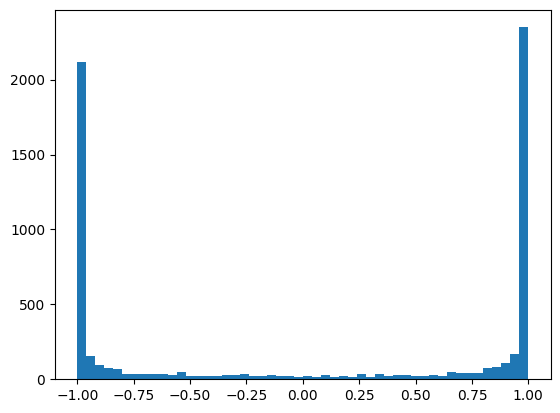

In [110]:
plt.hist(h.view(-1).tolist(), 50);

Awww... man...<br>
It's really bad, since derivative of tanh is (1 - tanh(x)**2) * out.grad<br>
We fall into these plane tales<br>

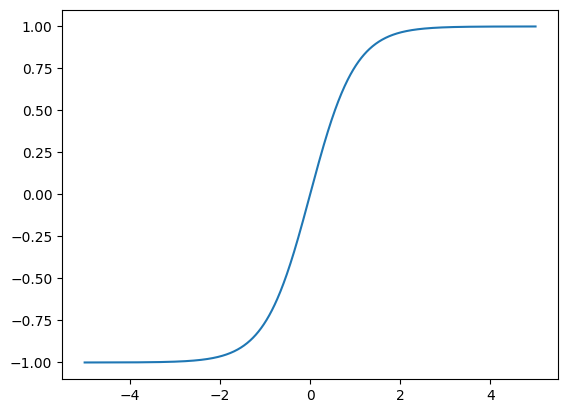

In [111]:
plt.plot(torch.linspace(-5, 5, 1000), F.tanh(torch.linspace(-5, 5, 1000)));

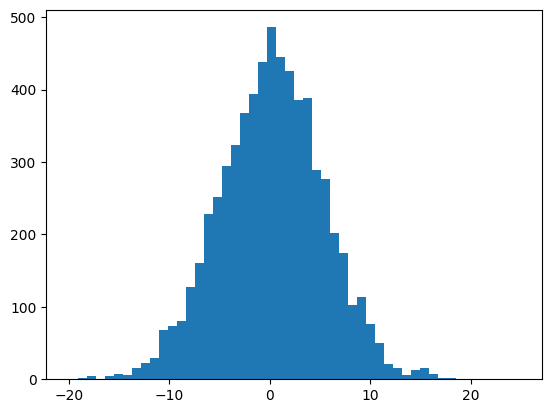

In [112]:
# Let's see how emb(x) is distributed

embcat = emb.view(emb.shape[0], -1)
preact = embcat @ W1 + b1

plt.hist(preact.view(-1).tolist(), 50);

As we can see it's a broad range of preactivation.<br>
Tanh plateaus from (-inf; -3] and from [3; +inf) (kinda)<br>
Even visually we can see that our gradient is DEAD

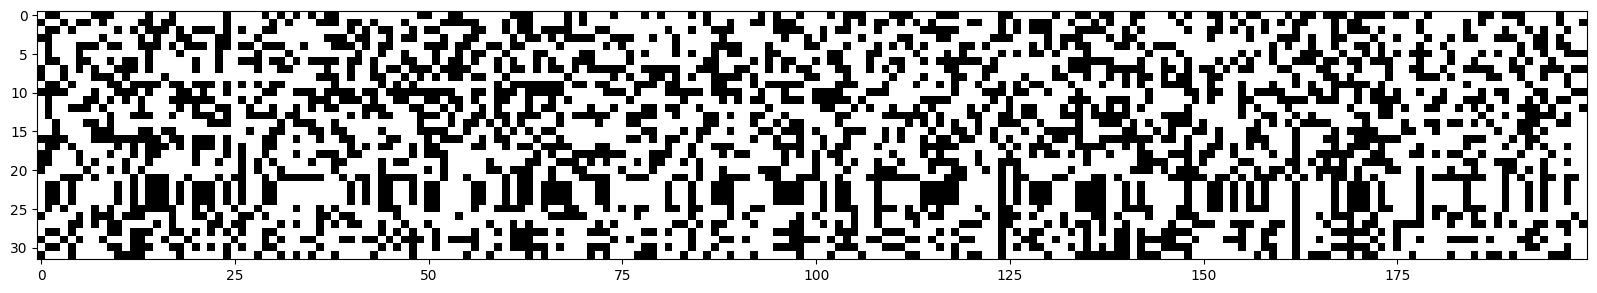

In [113]:
"""
Activation values per sample in batch (rows - samples; columns - neurons)
White stands for True (meaning it's > 0.99, meaning its gradient is 0)
Black stands for False.
Fully White column means that particular neuron is DEAD for given batch, since all inputs result in 0 grad & no learning happens 
"""
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray");

In [123]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((10*context_window, 200), generator=g) * 0.2
b1 = torch.randn(200, generator=g) * 0.01
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.01

parameters = [C, W1, b1, W2, b2]

lr = 0.1
batch_size = 32
epochs = 200_000

for p in parameters:
    p.requires_grad = True

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[batch]].view(-1, 10*context_window)
    preact = emb @ W1 + b1
    h = F.tanh(preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[batch])
    for p in parameters:
        p.grad = None
    loss.backward()
    if epoch >= 100_000: lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if epoch % 20_000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")
    break

Epoch: 0 | Loss: 3.3019378185272217


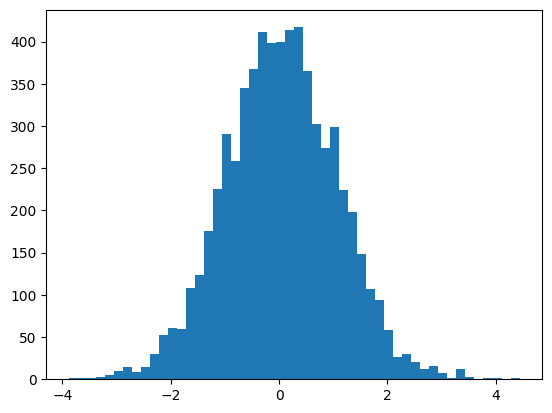

In [124]:
# Let's see how emb(x) is distributed now

plt.hist(preact.view(-1).tolist(), 50);

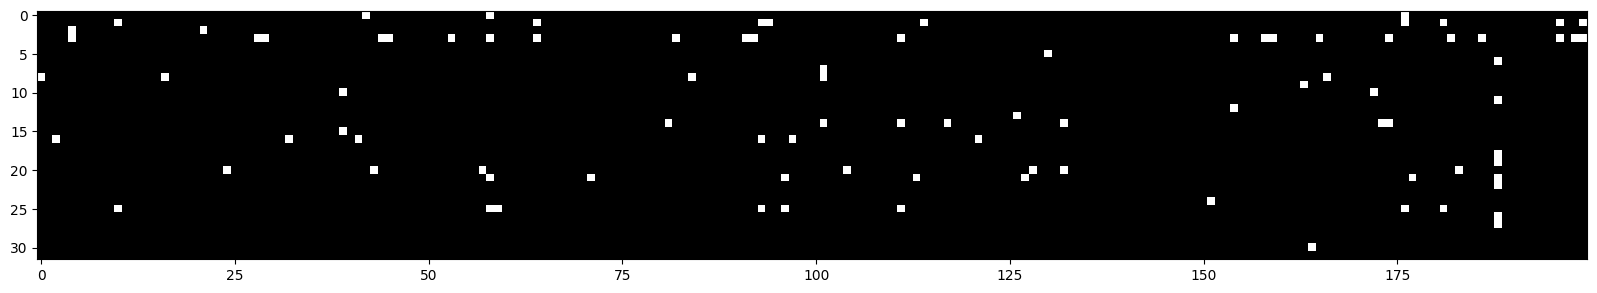

In [125]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray");

In [126]:
# Okay... Moment of truth!
# What performance do we get after full optimization???

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((10*context_window, 200), generator=g) * 0.2
b1 = torch.randn(200, generator=g) * 0.01
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.01

parameters = [C, W1, b1, W2, b2]

lr = 0.1
batch_size = 32
epochs = 200_000

for p in parameters:
    p.requires_grad = True

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[batch]].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[batch])
    for p in parameters:
        p.grad = None
    loss.backward()
    if epoch >= 100_000: lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if epoch % 20_000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 3.3223743438720703
Epoch: 20000 | Loss: 2.0869927406311035
Epoch: 40000 | Loss: 1.7434229850769043
Epoch: 60000 | Loss: 1.8115522861480713
Epoch: 80000 | Loss: 2.044328212738037
Epoch: 100000 | Loss: 2.046788215637207
Epoch: 120000 | Loss: 1.9425023794174194
Epoch: 140000 | Loss: 2.2191529273986816
Epoch: 160000 | Loss: 1.8374990224838257
Epoch: 180000 | Loss: 2.3455042839050293


In [127]:
with torch.inference_mode():
    emb = C[X_train].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    train_loss = F.cross_entropy(logits, y_train)

    emb = C[X_test].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    test_loss = F.cross_entropy(logits, y_test)

    print(f"Train loss: {train_loss}")
    print(f"Test loss: {test_loss}")

Train loss: 2.032926321029663
Test loss: 2.1172983646392822


In [130]:
# Sampling from our updated model (actually it's not. The weights are updated)

for i in range(10):
    res = ""
    context = [0] * context_window
    while True:
        emb = C[context].view(1, 30)
        h = F.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        res += itos[ix]
    print(res)

ruziti
mah
itzir
rutumaya
sel
neylah
jayraheesana
lexxajon
nistianni
liley


In [131]:
# But we scaled our weight in such a random way.
# It would be better to explain it somehow.
# In ideal we would like to have std of output y be the same as std of input x (remain preserved)
# Through mathematical analisys (perfectly described in UDL book) we get the following rule
# weigths * gain / input_neurons ** 0.5 (Gain depends on activation. For relu it's 2**0.5, since half of distribution is being cut off)
# Kaiming init

In [160]:
# Let's test it out!

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((10*context_window, 200), generator=g) * (5 / 3) / ((10*context_window) ** 0.5)
b1 = torch.randn(200, generator=g) * 0.01
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.01

parameters = [C, W1, b1, W2, b2]

lr = 0.1
batch_size = 32
epochs = 200_000

for p in parameters:
    p.requires_grad = True

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[batch]].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[batch])
    for p in parameters:
        p.grad = None
    loss.backward()
    if epoch >= 100_000: lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if epoch % 20_000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 3.3082988262176514
Epoch: 20000 | Loss: 2.089498996734619
Epoch: 40000 | Loss: 2.1214511394500732
Epoch: 60000 | Loss: 2.4324305057525635
Epoch: 80000 | Loss: 2.4296629428863525
Epoch: 100000 | Loss: 1.8523731231689453
Epoch: 120000 | Loss: 2.0772440433502197
Epoch: 140000 | Loss: 1.971740961074829
Epoch: 160000 | Loss: 2.0880446434020996
Epoch: 180000 | Loss: 1.9400006532669067


In [161]:
with torch.inference_mode():
    emb = C[X_train].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    train_loss = F.cross_entropy(logits, y_train)

    emb = C[X_test].view(-1, 10*context_window)
    h = F.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    test_loss = F.cross_entropy(logits, y_test)

    print(f"Train loss: {train_loss}")
    print(f"Test loss: {test_loss}")

Train loss: 2.0337975025177
Test loss: 2.117969512939453


In [165]:
# We discovered that normal distribution of preactivations is really desirable
# Too broad range can caues tanh oversaturation, while to narrow range results in tanh meaning loss
# BatchNorm comes to the rescue with a really simple, yet genius idea:
# "If normal distribution is so good, why don't ya guys just normalize preactivations, so that they're gaussian"
# BOOM!
# One important thing to mention is that we want our distribution to be normal only in the beginning
# If network needs distribution to be shifted or scaled it's wrong to force it to be normal
# This is why we introduce batchnorm bias and batchnorm gain parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((10*context_window, 200), generator=g) * (5 / 3) / ((10*context_window) ** 0.5)
b1 = torch.randn(200, generator=g) * 0.01
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.01

bngain = torch.ones((1, 200))
bnbias = torch.zeros((1, 200))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

lr = 0.05
batch_size = 32
epochs = 200_000

for p in parameters:
    p.requires_grad = True

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[batch]].view(-1, 10*context_window)
    preact = emb @ W1 + b1
    preact = bngain * (preact - preact.mean(dim=0, keepdims=True)) / preact.std(dim=0, keepdim=True) + bnbias
    h = F.tanh(preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[batch])
    for p in parameters:
        p.grad = None
    loss.backward()
    if epoch >= 100_000: lr = 0.005
    for p in parameters:
        p.data += -lr * p.grad
    if epoch % 20_000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 3.2815847396850586
Epoch: 20000 | Loss: 1.950512170791626
Epoch: 40000 | Loss: 2.056062698364258
Epoch: 60000 | Loss: 2.0432662963867188
Epoch: 80000 | Loss: 2.1106135845184326
Epoch: 100000 | Loss: 2.2285666465759277
Epoch: 120000 | Loss: 1.9757459163665771
Epoch: 140000 | Loss: 2.295198678970337
Epoch: 160000 | Loss: 2.0779359340667725
Epoch: 180000 | Loss: 1.786349892616272


In [166]:
with torch.inference_mode():
    emb = C[X_train].view(-1, 10*context_window)
    preact = emb @ W1 + b1
    preact = bngain * (preact - preact.mean(dim=0, keepdims=True)) / preact.std(dim=0, keepdim=True) + bnbias
    h = F.tanh(preact)
    logits = h @ W2 + b2
    train_loss = F.cross_entropy(logits, y_train)

    emb = C[X_test].view(-1, 10*context_window)
    preact = emb @ W1 + b1
    preact = bngain * (preact - preact.mean(dim=0, keepdims=True)) / preact.std(dim=0, keepdim=True) + bnbias
    h = F.tanh(preact)
    logits = h @ W2 + b2
    test_loss = F.cross_entropy(logits, y_test)

    print(f"Train loss: {train_loss}")
    print(f"Test loss: {test_loss}")  # These methods are applicable to big nets, here it's not that much of a deal

Train loss: 2.0749564170837402
Test loss: 2.126655340194702


In [ ]:
# BatchNorm doesn't only fix statistics of the batch
# It also works as a regularizer, because logits of particular example depend on surrounding batch
# It makes it harder for the net to overfit the data

# PROBLEM: On real job we will need to deploy or model to production.
# Most of modern models (especially generative) work with one input sample
# The calculation above would make no sense.

In [177]:
with torch.inference_mode():
    emb = C[torch.tensor([0,0,0])].view(-1, 10*context_window)
    preact = emb @ W1 + b1
    preact = bngain * (preact - preact.mean(dim=0, keepdims=True)) / preact.std(dim=0, keepdim=True) + bnbias
    print(preact)  # Oh shit..<

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

/tmp/ipykernel_5272/3936177234.py:4: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  preact = bngain * (preact - preact.mean(dim=0, keepdims=True)) / preact.std(dim=0, keepdim=True) + bnbias


In [179]:
# We have 2 ways of addressing this problem

# 1st: Calculate mean and std for entire training set and use it
with torch.inference_mode():
    emb = C[X_train].view(-1, 10*context_window)
    preact = emb @ W1 + b1
    bnmean = preact.mean(dim=0, keepdim=True)
    bnstd = preact.std(dim=0, keepdim=True)

with torch.inference_mode():
    emb = C[torch.tensor([0,0,0])].view(-1, 10*context_window)
    preact = emb @ W1 + b1
    preact = bngain * (preact - bnmean) / bnstd + bnbias
    print(preact)  # Well... That's something

tensor([[-1.1947e+00,  5.2659e-01,  1.3587e+00,  5.4304e-01,  1.5332e-02,
          2.7230e-01,  1.4891e+00, -1.9287e-01, -2.6217e-01, -7.2412e-01,
         -1.0475e+00,  3.2086e-01, -6.6389e-01,  5.4620e-01,  5.0400e-01,
          3.4542e-01, -2.1727e-01, -6.0799e-01, -4.7133e-01, -1.1061e+00,
         -2.0804e-02,  3.4599e-01, -3.0180e-01,  3.0007e-01, -1.4577e-01,
          8.2168e-01,  1.0595e-01, -1.5949e-01, -8.2560e-01, -1.4932e-01,
         -1.6321e-01, -7.6299e-01,  1.9197e+00,  2.3434e-01, -2.3167e-01,
          2.0356e-01, -1.0298e+00, -1.1051e+00,  1.3390e+00,  6.3896e-01,
         -5.4177e-01,  1.9031e-01,  5.5555e-01, -2.3936e-01,  9.6409e-02,
         -2.2578e-01, -1.0217e+00, -7.0278e-01, -1.5644e+00,  8.9538e-01,
         -7.6290e-01,  6.4323e-01,  5.5658e-02,  1.3950e-01,  5.5847e-01,
          6.7406e-02,  1.7642e-01, -9.3076e-01,  1.4799e+00,  4.2566e-01,
         -4.1085e-02, -6.4799e-01,  1.3140e-01,  1.1973e+00,  2.9258e-01,
          1.7074e-01, -2.0664e-01,  9.

In [181]:
# But honestly, this approach sucks, since for larger network we'll need to introduce these preactivations
# And calculate all this stuff after training... No no no...

# 2nd Approach (better one and used in PyTorch BatchNorm)
# Running mean and std

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((10*context_window, 200), generator=g) * (5 / 3) / ((10*context_window) ** 0.5)
# b1 = torch.randn(200, generator=g) * 0.01
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.01

bngain = torch.ones((1, 200))
bnbias = torch.zeros((1, 200))  # b1 is not needed. It's being subtracted by the mean

# Running statistics initialized
running_mean = torch.zeros((1, 200))
running_std = torch.ones((1, 200))

parameters = [C, W1, W2, b2, bngain, bnbias]

lr = 0.05
batch_size = 32
epochs = 200_000

for p in parameters:
    p.requires_grad = True

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[batch]].view(-1, 10*context_window)
    preact = emb @ W1 # + b1

    # Current batch statistics
    bn_mean_i = preact.mean(dim=0, keepdims=True)
    bn_std_i = preact.std(dim=0, keepdim=True)
    
    preact = bngain * (preact - bn_mean_i) / bn_std_i + bnbias

    # Adding batch mean in running matter
    with torch.inference_mode():
        running_mean = 0.999 * running_mean + 0.001 * bn_mean_i
        running_std = 0.999 * running_std + 0.001 * bn_std_i
    
    h = F.tanh(preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[batch])
    for p in parameters:
        p.grad = None
    loss.backward()
    if epoch >= 100_000: lr = 0.005
    for p in parameters:
        p.data += -lr * p.grad
    if epoch % 20_000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 3.3045637607574463
Epoch: 20000 | Loss: 2.047680377960205
Epoch: 40000 | Loss: 2.1588785648345947
Epoch: 60000 | Loss: 2.0403599739074707
Epoch: 80000 | Loss: 2.476025342941284
Epoch: 100000 | Loss: 1.9808335304260254
Epoch: 120000 | Loss: 2.1689417362213135
Epoch: 140000 | Loss: 1.6830430030822754
Epoch: 160000 | Loss: 1.919463872909546
Epoch: 180000 | Loss: 2.2027170658111572


In [184]:
# It will give us simmilar, yet not exactly same values for mean and std over training set

with torch.inference_mode():
    emb = C[torch.tensor([0,0,0])].view(-1, 10*context_window)
    preact = emb @ W1
    preact = bngain * (preact - running_mean) / running_std + bnbias
    print(preact)  # Well... That's something simmilar

tensor([[-1.3333e+00,  5.5346e-01,  1.1952e+00,  6.9466e-01, -3.9353e-01,
          5.9881e-02,  1.5438e+00,  1.5640e-02, -1.0109e-01, -5.4955e-01,
         -2.0252e-01, -1.2523e-02, -1.3038e-01,  3.4123e-01,  4.0635e-01,
         -1.5207e-01, -4.2568e-01, -4.0591e-01, -6.1423e-01, -1.1703e+00,
         -2.7207e-01, -1.9909e-02,  3.4154e-02,  4.6910e-01, -2.2443e-01,
          3.0791e-01,  3.6071e-01,  7.3897e-02, -5.4396e-01,  5.2761e-01,
         -1.0519e-01, -9.3009e-01,  1.5635e+00,  4.0947e-01, -5.5074e-01,
         -6.6442e-01, -2.3223e+00, -9.9747e-01,  1.2126e+00,  2.3627e-01,
         -5.4509e-01, -4.3320e-01,  6.7430e-01, -4.3897e-01,  3.3631e-01,
          1.2550e+00, -1.1706e+00, -8.1598e-01, -1.6078e+00,  9.9432e-01,
          2.6368e-01,  4.2569e-01, -2.1327e-01,  3.9855e-02,  5.2632e-01,
         -9.4593e-02,  6.4766e-02, -1.0154e+00,  1.7299e+00,  3.1498e-01,
          1.6497e-02, -1.0693e-01, -7.0587e-02,  5.8221e-01,  4.9450e-01,
         -1.2735e-01, -1.5946e-02,  1.

That's it for today!<br>
## Andrej Was just kidding. Fun continues!

In [274]:
"""
Time for real deal! Let's make code more PyTorch-like.
"""

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # running statistics (in pytorch such variables trained with momentum accumulation are called 'buffers')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            mean_x = x.mean(0, keepdim=True)
            var_x = x.var(0, keepdim=True)
        else:
            mean_x = self.running_mean
            var_x = self.running_var
        x_hat = (x - mean_x) / torch.sqrt(var_x + self.eps)
        self.out = self.gamma * x_hat + self.beta
        if self.training:
            with torch.inference_mode():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean_x
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var_x
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [244]:
vocab_size = 27
emb_dim = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, emb_dim), generator=g)
layers = [
    Linear(emb_dim * context_window, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, vocab_size),
]

with torch.inference_mode():
    layers[-1].weight *= 0.1  # make softmax logits less confident
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1  # NO GAIN JUST TO SHOW HOW BAD IT IS!!! (IT'S WRONG!!!)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

46497


In [245]:
# Optimization
epochs = 200_000
batch_size = 32
loss_i = []

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, y_batch = X_train[batch], y_train[batch]
    # forward pass
    emb = C[X_batch]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_batch)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Stats tracking
    if epoch % 10_000 == 0:
        print(f"{epoch}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())
    if epoch > 1000:
        break

0: 3.2954


layer 1 (Tanh), mean: -0.035514555871486664, std: <built-in method std of Tensor object at 0x77a849e235c0>, saturated_rate: 5.78125%
layer 3 (Tanh), mean: 0.0036442705895751715, std: <built-in method std of Tensor object at 0x77a849c648c0>, saturated_rate: 0.65625%
layer 5 (Tanh), mean: 0.012367398478090763, std: <built-in method std of Tensor object at 0x77a84a0bb6b0>, saturated_rate: 0.65625%
layer 7 (Tanh), mean: -0.030952606350183487, std: <built-in method std of Tensor object at 0x77a84a0bbde0>, saturated_rate: 0.3125%
layer 9 (Tanh), mean: 0.013910370878875256, std: <built-in method std of Tensor object at 0x77a849e803c0>, saturated_rate: 0.1875%


Text(0.5, 1.0, 'activation distribution (NO GAIN)')

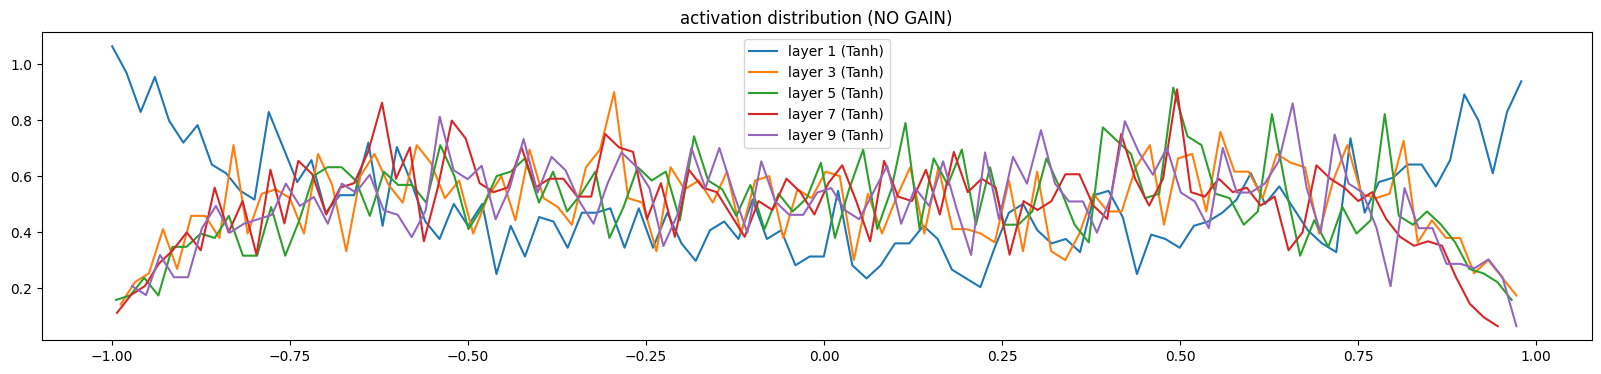

In [246]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} ({layer.__class__.__name__}), mean: {t.mean()}, std: {t.std}, saturated_rate: {(t.abs() > 0.97).float().mean()*100}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("activation distribution (NO GAIN)")

In [247]:
# But let's reaturn to sane reality

vocab_size = 27
emb_dim = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, emb_dim), generator=g)
layers = [
    Linear(emb_dim * context_window, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, vocab_size),
]

with torch.inference_mode():
    layers[-1].weight *= 0.1  # make softmax logits less confident
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

# Optimization
epochs = 200_000
batch_size = 32
loss_i = []

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, y_batch = X_train[batch], y_train[batch]
    # forward pass
    emb = C[X_batch]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_batch)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Stats tracking
    if epoch % 10_000 == 0:
        print(f"{epoch}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())
    if epoch > 1_000:
        break

46497
0: 3.2944


layer 1 (Tanh), mean: -0.039153020828962326, std: <built-in method std of Tensor object at 0x77a849beab20>, saturated_rate: 23.0625%
layer 3 (Tanh), mean: -0.0177362821996212, std: <built-in method std of Tensor object at 0x77a849b02ee0>, saturated_rate: 11.46875%
layer 5 (Tanh), mean: 2.9209256808826467e-06, std: <built-in method std of Tensor object at 0x77a849beaee0>, saturated_rate: 13.875%
layer 7 (Tanh), mean: -0.047467030584812164, std: <built-in method std of Tensor object at 0x77a849beada0>, saturated_rate: 12.4375%
layer 9 (Tanh), mean: -0.0025599789805710316, std: <built-in method std of Tensor object at 0x77a849beadf0>, saturated_rate: 10.375%


Text(0.5, 1.0, 'activation distribution')

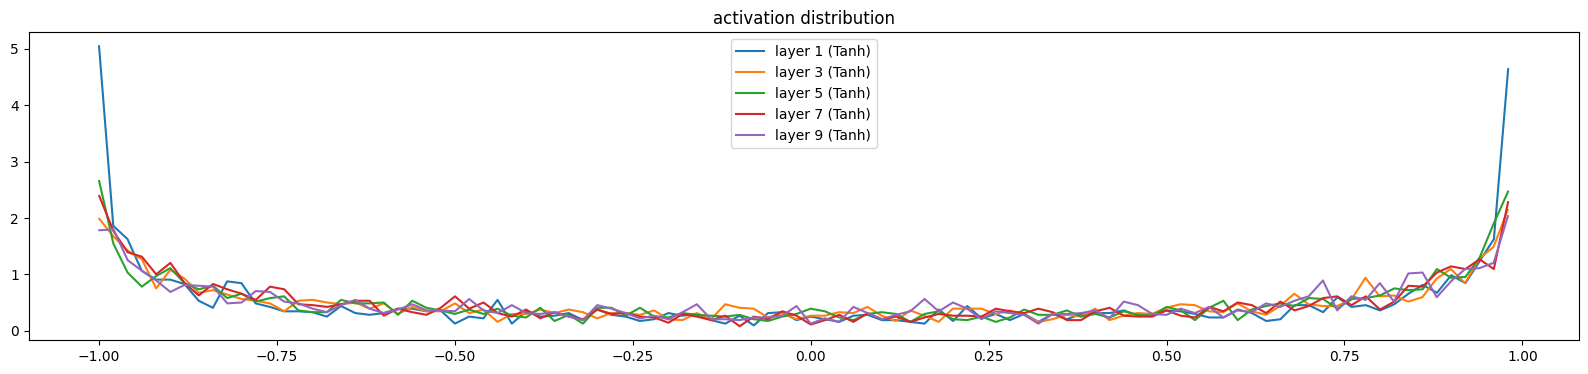

In [248]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} ({layer.__class__.__name__}), mean: {t.mean()}, std: {t.std}, saturated_rate: {(t.abs() > 0.97).float().mean()*100}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("activation distribution")

layer 1 (Tanh), mean: 3.1316913009504788e-06, std: <built-in method std of Tensor object at 0x77a849a7e1c0>, saturated_rate: 0.0%
layer 3 (Tanh), mean: -4.8743699153419584e-05, std: <built-in method std of Tensor object at 0x77a849b77de0>, saturated_rate: 0.0%
layer 5 (Tanh), mean: -4.529489524429664e-05, std: <built-in method std of Tensor object at 0x77a849a06e40>, saturated_rate: 0.0%
layer 7 (Tanh), mean: -4.176737547822995e-06, std: <built-in method std of Tensor object at 0x77a849beb8e0>, saturated_rate: 0.0%
layer 9 (Tanh), mean: 1.6903883079066873e-05, std: <built-in method std of Tensor object at 0x77a849a7e210>, saturated_rate: 0.0%


Text(0.5, 1.0, 'grad distribution')

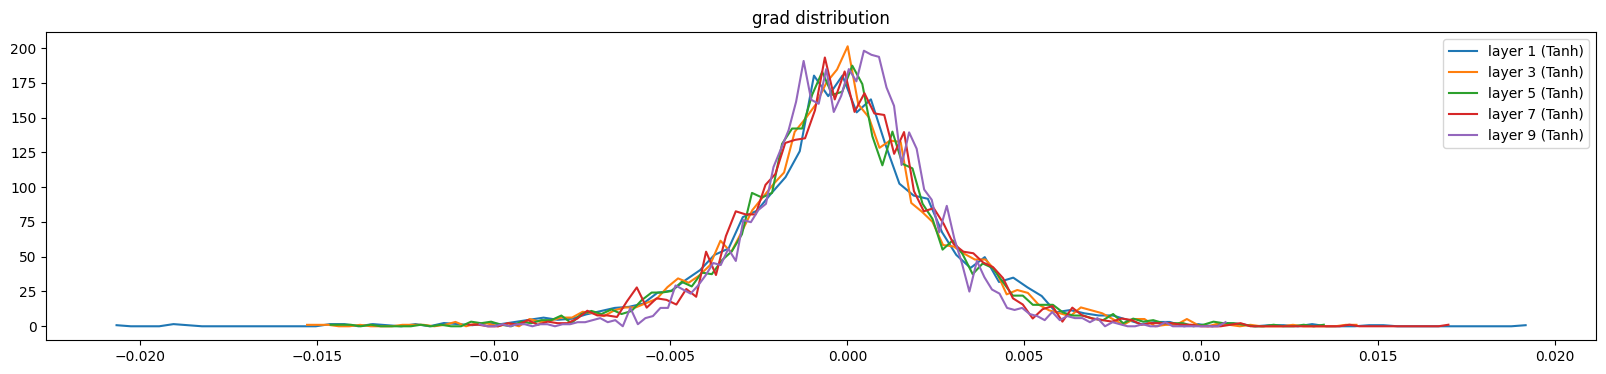

In [249]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} ({layer.__class__.__name__}), mean: {t.mean()}, std: {t.std}, saturated_rate: {(t.abs() > 0.97).float().mean()*100}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("grad distribution")

46497
0: 3.2954
layer 0 (Linear), mean: -0.06393543630838394, std: <built-in method std of Tensor object at 0x77a849afe490>, saturated_rate: 33.71875%
layer 1 (Linear), mean: -0.0253354050219059, std: <built-in method std of Tensor object at 0x77a849a35590>, saturated_rate: 31.687501907348633%
layer 2 (Linear), mean: 0.006679119076579809, std: <built-in method std of Tensor object at 0x77a849a35630>, saturated_rate: 31.5%
layer 3 (Linear), mean: 0.014952314086258411, std: <built-in method std of Tensor object at 0x77a849a35c70>, saturated_rate: 31.843748092651367%
layer 4 (Linear), mean: -0.0598406046628952, std: <built-in method std of Tensor object at 0x77a849893750>, saturated_rate: 31.78125%


Text(0.5, 1.0, 'linear distribution')

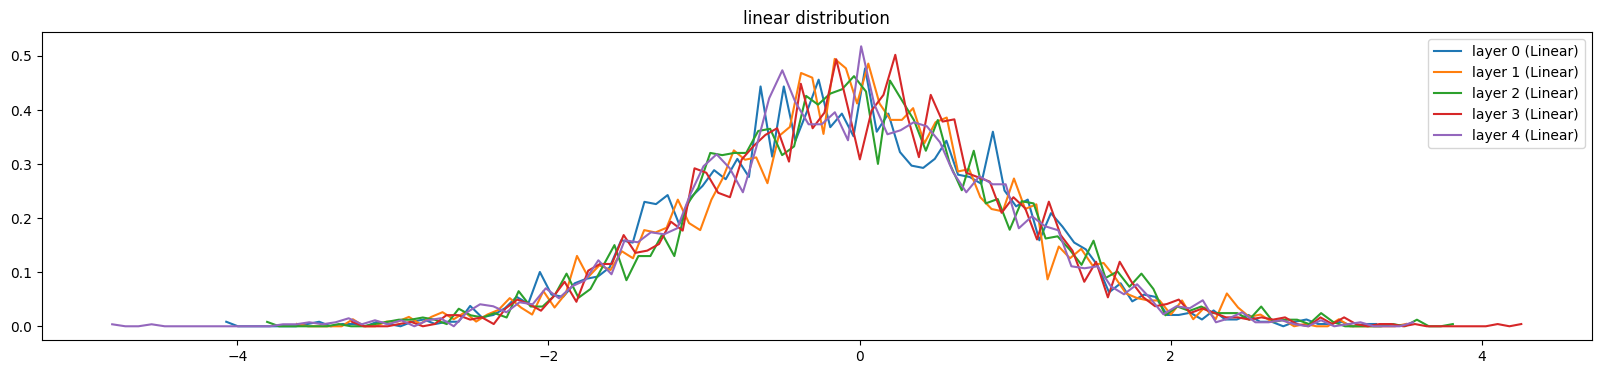

In [256]:
# Let's see Linear Layers

vocab_size = 27
emb_dim = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, emb_dim), generator=g)
layers = [
    Linear(emb_dim * context_window, n_hidden), #Tanh(),
    Linear(                n_hidden, n_hidden), #Tanh(),
    Linear(                n_hidden, n_hidden), #Tanh(),
    Linear(                n_hidden, n_hidden), #Tanh(),
    Linear(                n_hidden, n_hidden), #Tanh(),
    Linear(                n_hidden, vocab_size),
]

with torch.inference_mode():
    layers[-1].weight *= 0.1  # make softmax logits less confident
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

# Optimization
epochs = 200_000
batch_size = 32
loss_i = []

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, y_batch = X_train[batch], y_train[batch]
    # forward pass
    emb = C[X_batch]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_batch)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Stats tracking
    if epoch % 10_000 == 0:
        print(f"{epoch}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())
    
    break

plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out
        print(f"layer {i} ({layer.__class__.__name__}), mean: {t.mean()}, std: {t.std}, saturated_rate: {(t.abs() > 0.97).float().mean()*100}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("linear distribution")

layer 0 (Linear), mean: -0.06393543630838394, std: <built-in method std of Tensor object at 0x77a849afe490>, saturated_rate: 33.71875%
layer 1 (Linear), mean: -0.0253354050219059, std: <built-in method std of Tensor object at 0x77a849a35590>, saturated_rate: 31.687501907348633%
layer 2 (Linear), mean: 0.006679119076579809, std: <built-in method std of Tensor object at 0x77a849a35630>, saturated_rate: 31.5%
layer 3 (Linear), mean: 0.014952314086258411, std: <built-in method std of Tensor object at 0x77a849a35c70>, saturated_rate: 31.843748092651367%
layer 4 (Linear), mean: -0.0598406046628952, std: <built-in method std of Tensor object at 0x77a849893750>, saturated_rate: 31.78125%


Text(0.5, 1.0, 'linear grad distribution')

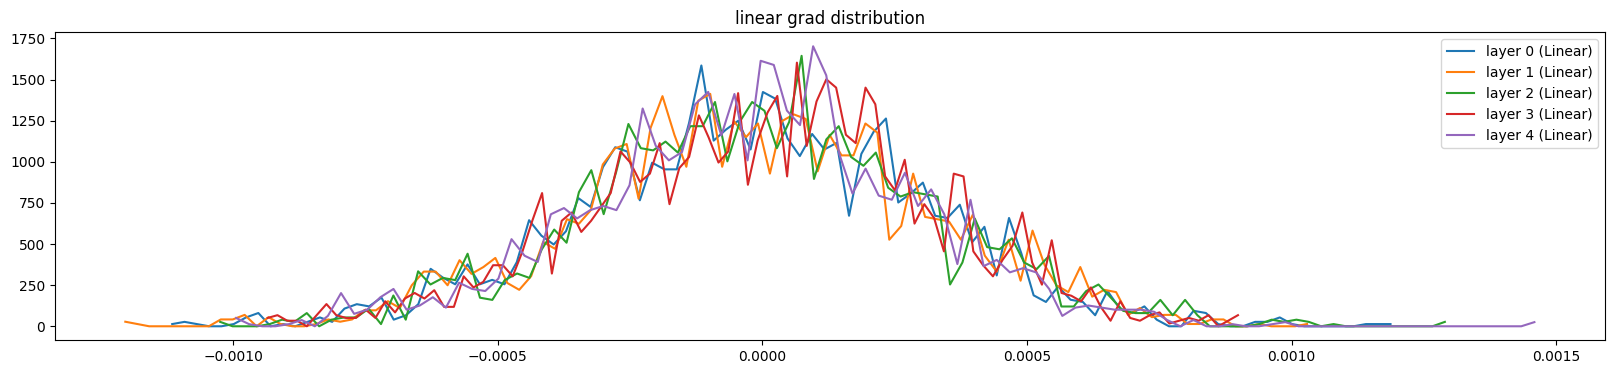

In [257]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out.grad
        print(f"layer {i} ({layer.__class__.__name__}), mean: {t.mean()}, std: {t.std}, saturated_rate: {(t.abs() > 0.97).float().mean()*100}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("linear grad distribution")

0 (torch.Size([27, 10])), mean: -0.00012566284567583352, std: 0.001224513747729361, grad:data ratio: 0.0012236294569447637
1 (torch.Size([30, 100])), mean: 2.0159766791039146e-05, std: 0.0019488045945763588, grad:data ratio: 0.01041486393660307
3 (torch.Size([100, 100])), mean: -1.6728289438106003e-06, std: 0.0021085254848003387, grad:data ratio: 0.02115461975336075
5 (torch.Size([100, 100])), mean: -5.707623131456785e-06, std: 0.002037761500105262, grad:data ratio: 0.02022988349199295
7 (torch.Size([100, 100])), mean: 1.7048556401277892e-05, std: 0.0020223772153258324, grad:data ratio: 0.020161520689725876
9 (torch.Size([100, 100])), mean: -3.09366718909132e-08, std: 0.0019259568070992827, grad:data ratio: 0.019181689247488976
11 (torch.Size([100, 27])), mean: 0.0, std: 0.03851914405822754, grad:data ratio: 3.63464093208313


Text(0.5, 1.0, 'weights grad distribution')

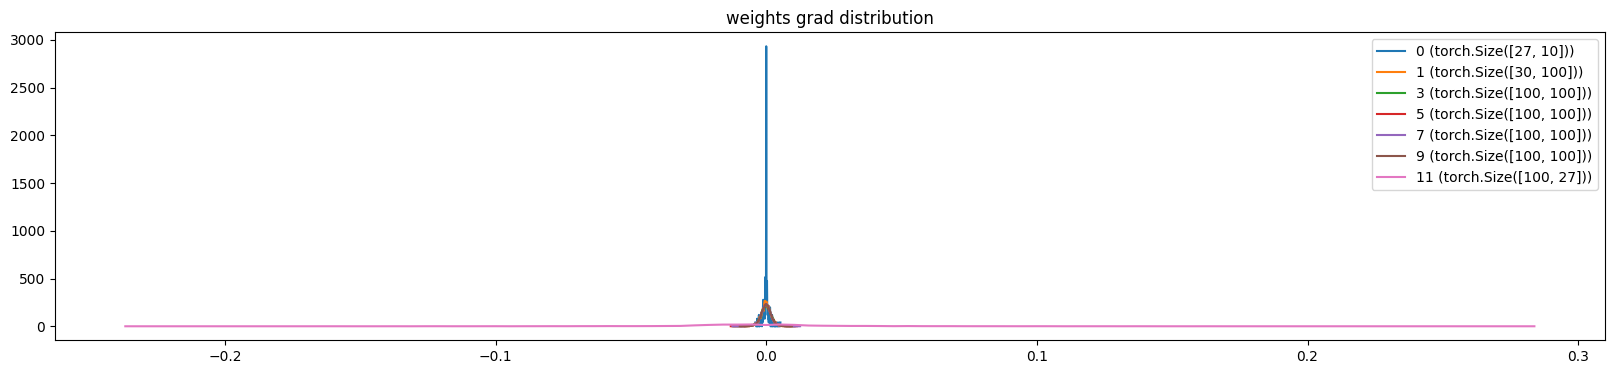

In [258]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print(f"{i} ({p.shape}), mean: {t.mean()}, std: {t.std()}, grad:data ratio: {t.std() / p.std()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} ({p.shape})")
plt.legend(legends);
plt.title("weights grad distribution")

46497
0: 3.2954
0 (torch.Size([27, 10])), mean: -2.8874001145595685e-05, std: 0.011112645268440247, grad:data ratio: 0.011328451335430145
1 (torch.Size([30, 100])), mean: -0.0001367555232718587, std: 0.010219341143965721, grad:data ratio: 0.056583650410175323
3 (torch.Size([100, 100])), mean: 7.302293670363724e-05, std: 0.007351550739258528, grad:data ratio: 0.07499238848686218
5 (torch.Size([100, 100])), mean: 3.167199611198157e-05, std: 0.005730462726205587, grad:data ratio: 0.058528777211904526
7 (torch.Size([100, 100])), mean: -1.7979326003114693e-05, std: 0.005273778457194567, grad:data ratio: 0.05416799336671829
9 (torch.Size([100, 100])), mean: 1.818005694076419e-05, std: 0.005477806553244591, grad:data ratio: 0.05636214092373848
11 (torch.Size([100, 27])), mean: -9.934107703113426e-11, std: 0.019701777026057243, grad:data ratio: 0.3657817840576172


Text(0.5, 1.0, 'weights grad distribution')

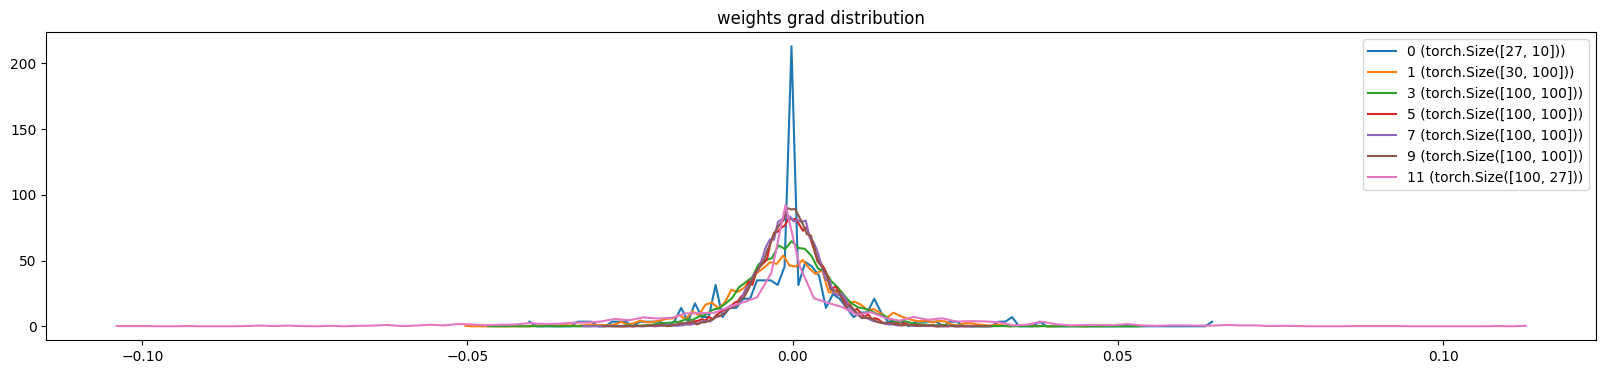

In [260]:
# Oh... Here's the trouble, since in last layer there's no squashing function like Tanh
# Thankfully it means that last layer in general trains faster (gradient is untouched)
# Let's see if it's fixed with a bit of a training now

# Let's see Linear Layers

vocab_size = 27
emb_dim = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, emb_dim), generator=g)
layers = [
    Linear(emb_dim * context_window, n_hidden), #Tanh(),
    Linear(                n_hidden, n_hidden), #Tanh(),
    Linear(                n_hidden, n_hidden), #Tanh(),
    Linear(                n_hidden, n_hidden), #Tanh(),
    Linear(                n_hidden, n_hidden), #Tanh(),
    Linear(                n_hidden, vocab_size),
]

with torch.inference_mode():
    layers[-1].weight *= 0.1  # make softmax logits less confident
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

# Optimization
epochs = 200_000
batch_size = 32
loss_i = []

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, y_batch = X_train[batch], y_train[batch]
    # forward pass
    emb = C[X_batch]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_batch)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Stats tracking
    if epoch % 10_000 == 0:
        print(f"{epoch}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())
    if epoch > 1_000:  # DO A BIT OF TRAINING BEFORE PLOT
        break

plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print(f"{i} ({p.shape}), mean: {t.mean()}, std: {t.std()}, grad:data ratio: {t.std() / p.std()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} ({p.shape})")
plt.legend(legends);
plt.title("weights grad distribution")

46497
0: 3.2944


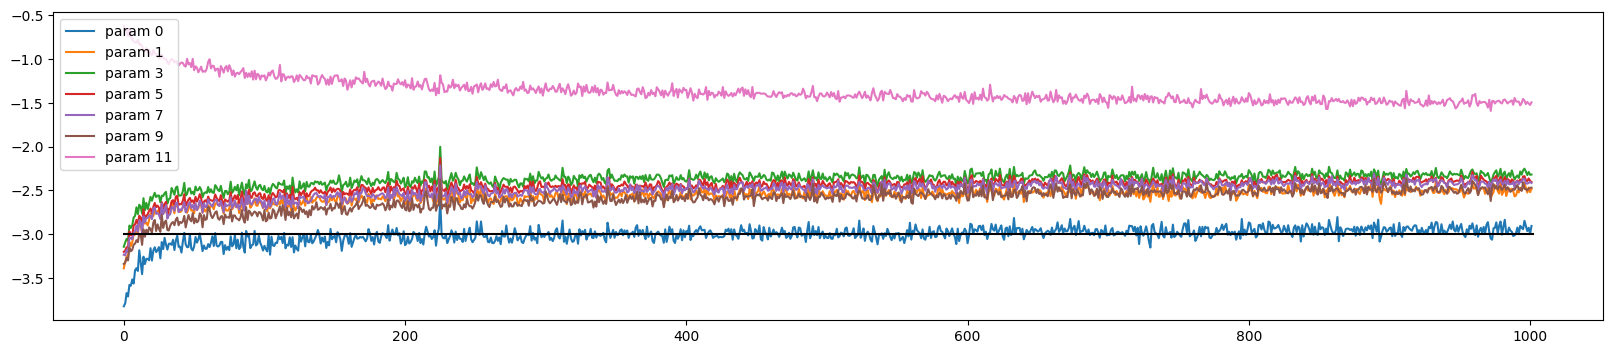

In [266]:
# Last visualization is a visualization of update to data relation

# Oh... Here's the trouble, since in last layer there's no squashing function like Tanh
# Thankfully it means that last layer in general trains faster (gradient is untouched)
# Let's see if it's fixed with a bit of a training now

# Let's see Linear Layers

vocab_size = 27
emb_dim = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, emb_dim), generator=g)
layers = [
    Linear(emb_dim * context_window, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, vocab_size),
]

with torch.inference_mode():
    layers[-1].weight *= 0.1  # make softmax logits less confident
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

# Optimization
epochs = 200_000
batch_size = 32
loss_i = []

upd_to_data = []

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, y_batch = X_train[batch], y_train[batch]
    # forward pass
    emb = C[X_batch]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_batch)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Stats tracking
    if epoch % 10_000 == 0:
        print(f"{epoch}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())
    with torch.inference_mode():
        upd_to_data.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if epoch > 1_000:  # DO A BIT OF TRAINING BEFORE PLOT
        break

plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([upd_to_data[j][i] for j in range(len(upd_to_data))])
        legends.append(f"param {i}")
plt.plot([0, len(upd_to_data)], [-3, -3], "k")  # They should be ~1e-3, otherwise it's either too much or not enough
plt.legend(legends);

47551
0: 3.2703
layer 2 (Tanh), mean: -0.00744997151196003, std: <built-in method std of Tensor object at 0x77a849122440>, saturated_rate: 2.84375%
layer 5 (Tanh), mean: -0.00031894564745016396, std: <built-in method std of Tensor object at 0x77a849122a30>, saturated_rate: 2.53125%
layer 8 (Tanh), mean: -0.0011949395993724465, std: <built-in method std of Tensor object at 0x77a849021a40>, saturated_rate: 2.03125%
layer 11 (Tanh), mean: 0.0009590554400347173, std: <built-in method std of Tensor object at 0x77a849122cb0>, saturated_rate: 2.0625%
layer 14 (Tanh), mean: -0.00701169716194272, std: <built-in method std of Tensor object at 0x77a848b2b4d0>, saturated_rate: 2.03125%


Text(0.5, 1.0, 'activation distribution')

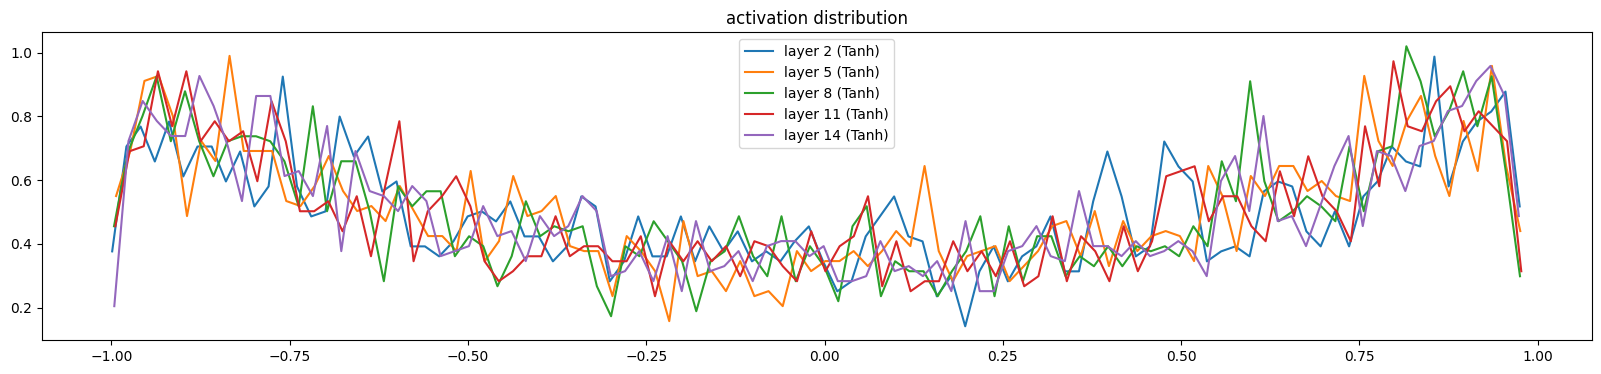

In [282]:
# Btw it's interesting how last layer updates to data are this high
# It's because we artificially lowered weights for this layer by a factor of 0.1 (to make net less confident)


# Alright, Finally! Let's add batch norm and see how it comes to the rescue!
# Oh... Here's the trouble, since in last layer there's no squashing function like Tanh
# Thankfully it means that last layer in general trains faster (gradient is untouched)
# Let's see if it's fixed with a bit of a training now

# Let's see Linear Layers

vocab_size = 27
emb_dim = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, emb_dim), generator=g)
layers = [
    Linear(emb_dim * context_window, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(                n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.inference_mode():
    layers[-1].gamma *= 0.1  # Now, last layer is BN so we lower its gamma parameter
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

# Optimization
epochs = 200_000
batch_size = 32
loss_i = []

upd_to_data = []

for epoch in range(epochs):
    batch = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, y_batch = X_train[batch], y_train[batch]
    # forward pass
    emb = C[X_batch]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_batch)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Stats tracking
    if epoch % 10_000 == 0:
        print(f"{epoch}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())
    with torch.inference_mode():
        upd_to_data.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if epoch > 1_000:  # DO A BIT OF TRAINING BEFORE PLOT
        break

plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} ({layer.__class__.__name__}), mean: {t.mean()}, std: {t.std}, saturated_rate: {(t.abs() > 0.97).float().mean()*100}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("activation distribution")

In [283]:
# Positive effect on activation distributions!
# We can see that every value occurs more or less commonly and extremes (like -1 and 1) are rare

layer 2 (Tanh), mean: -2.9103830890414573e-12, std: <built-in method std of Tensor object at 0x77a848a59400>, saturated_rate: 0.0%
layer 5 (Tanh), mean: 3.14321381422733e-11, std: <built-in method std of Tensor object at 0x77a849123c50>, saturated_rate: 0.0%
layer 8 (Tanh), mean: 4.656612768993984e-12, std: <built-in method std of Tensor object at 0x77a848a59220>, saturated_rate: 0.0%
layer 11 (Tanh), mean: 2.328306384496992e-12, std: <built-in method std of Tensor object at 0x77a848e71770>, saturated_rate: 0.0%
layer 14 (Tanh), mean: 1.571606907113665e-11, std: <built-in method std of Tensor object at 0x77a848a596d0>, saturated_rate: 0.0%


Text(0.5, 1.0, 'activation distribution')

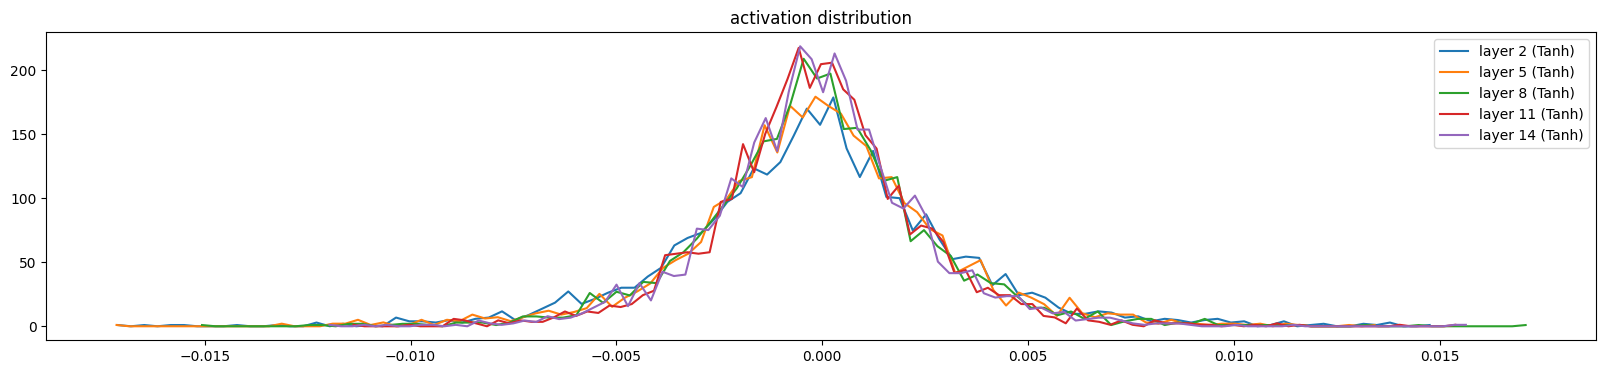

In [284]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} ({layer.__class__.__name__}), mean: {t.mean()}, std: {t.std}, saturated_rate: {(t.abs() > 0.97).float().mean()*100}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("activation distribution")

0 (torch.Size([27, 10])), mean: 7.933488588296456e-11, std: 0.008462924510240555, grad:data ratio: 0.00845431163907051
1 (torch.Size([30, 100])), mean: 0.00027469336055219173, std: 0.008155707269906998, grad:data ratio: 0.02609354443848133
5 (torch.Size([100, 100])), mean: -2.0897548893117346e-05, std: 0.006781204137951136, grad:data ratio: 0.04056819900870323
9 (torch.Size([100, 100])), mean: -3.4611170121934265e-05, std: 0.005984456278383732, grad:data ratio: 0.035485975444316864
13 (torch.Size([100, 100])), mean: -1.4605295291403309e-05, std: 0.005549768917262554, grad:data ratio: 0.0330669991672039
17 (torch.Size([100, 100])), mean: -4.900356361758895e-05, std: 0.005029023624956608, grad:data ratio: 0.029955629259347916
21 (torch.Size([100, 27])), mean: 3.664906762423925e-05, std: 0.009684604592621326, grad:data ratio: 0.05810333415865898


Text(0.5, 1.0, 'weights grad distribution')

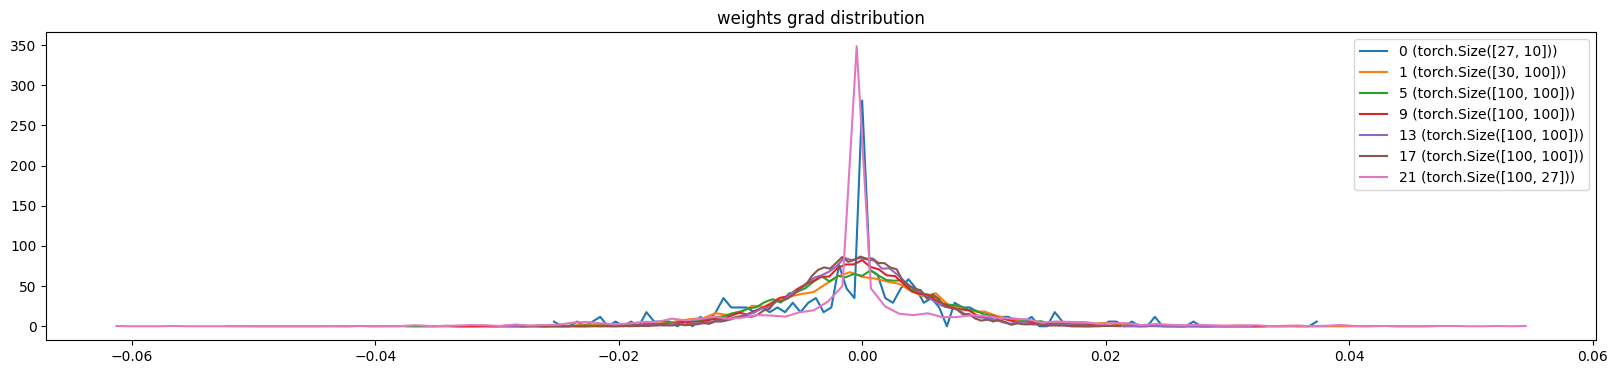

In [285]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print(f"{i} ({p.shape}), mean: {t.mean()}, std: {t.std()}, grad:data ratio: {t.std() / p.std()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} ({p.shape})")
plt.legend(legends);
plt.title("weights grad distribution")

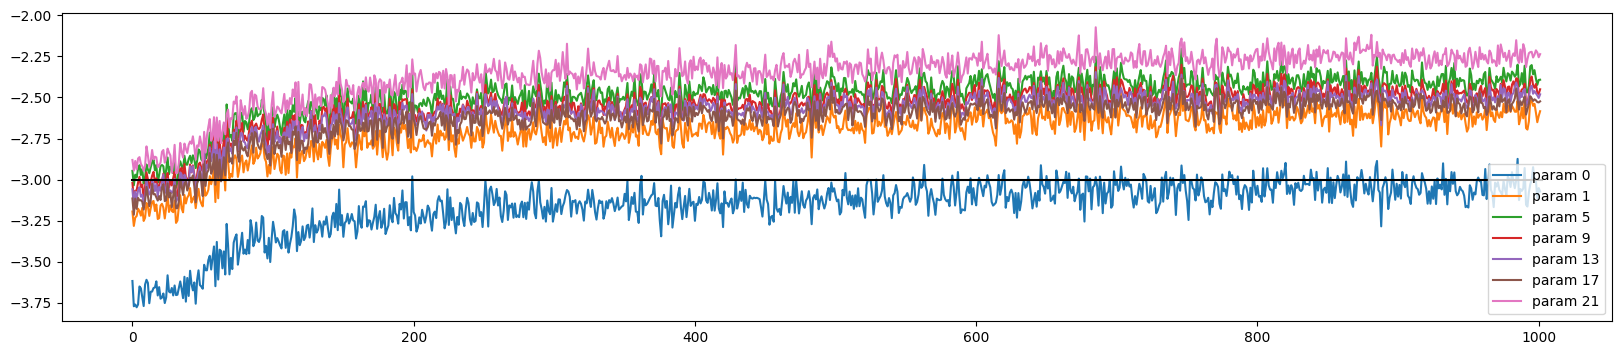

In [286]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([upd_to_data[j][i] for j in range(len(upd_to_data))])
        legends.append(f"param {i}")
plt.plot([0, len(upd_to_data)], [-3, -3], "k")  # They should be ~1e-3, otherwise it's either too much or not enough
plt.legend(legends);

### SUPER HOT! Batch Norm makes situation so much better by just normalizing preactivations!
### Of course with its cost...
With BN we're robust to gain in weight initializaton (but careful with scales, to avoid last layer-like situation)

# In summary:
In this lecture Andrej explained how Batch Normalization works and why it's such a good thing.<br>
It prevents activation function oversaturation and dying gradient by normalizing data in each batch.<br>
It also works as a regularization, since we add some noise to the data by subtracting batch mean.<br>
It yields a problem on inference, which can be resolved by calculating running statistics of the training set.<br>
There's also a discussion on weights initialization in the beginning, but it's not that much of a deal here.<br>
Just parameter scaling and smarter Kaiming initialization<br>
That's it! Time for retirement!